# 🎵 HarmonAIze — Data Preprocessing Notebook

This notebook prepares a curated subset of the **Spotify 1 Million Tracks** dataset for modeling.

We’ll perform:

1. Data loading and inspection
2. Data cleaning (drop nulls, duplicates)
3. Feature selection (audio-based features only)
4. Normalization and encoding
5. Saving processed data

---


## Imports

We import libraries for:
- **Data handling:** `pandas`, `numpy`
- **Preprocessing & scaling:** `scikit-learn`
- **Persistence:** `joblib` for saving scalers
- **Visualization:** optional EDA tools (`matplotlib`, `seaborn`)


In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


## Step 1: Load Dataset

We load the **Spotify 1 Million Tracks** dataset (available on Kaggle).
Make sure the CSV file is downloaded into `data/raw/spotify_1m.csv`.

---

The dataset typically includes columns like:
- `track_name`, `artists`, `genre`
- `danceability`, `energy`, `valence`, `tempo`, `acousticness`, `instrumentalness`, `liveness`, `speechiness`, `loudness`
- `duration_ms`, `popularity`


In [39]:
df = pd.read_csv("../../data/raw/spotify_1m.csv")
print("Shape:", df.shape)
df.head()


Shape: (1159764, 20)


,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


## Step 2: Data Cleaning

We:
- Drop unnamed columns (index artifacts)
- Remove duplicates and nulls
- Convert duration from ms → seconds for consistency

In [40]:
# Drop any unnamed index columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Drop duplicate track entries
df = df.drop_duplicates(subset=["track_name", "artist_name"])

# Drop missing rows in key columns
df = df.dropna(subset=[
    "track_name", "artist_name",
    "danceability", "energy", "valence",
    "acousticness", "tempo", "popularity"
])

# Convert duration to seconds
df["duration_sec"] = df["duration_ms"] / 1000

print("After cleaning:", df.shape)
df.head()


After cleaning: (1159748, 20)


,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,duration_sec
0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3,240.166
1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4,216.387
2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4,158.960
3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4,304.293
4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4,244.320


## Step 3: Feature Selection

We’ll focus on the following **acoustic and rhythmic features** for our recommendation engine:
- `danceability` — how suitable the track is for dancing
- `energy` — intensity and activity
- `valence` — musical positivity
- `acousticness` — acoustic vs electronic
- `instrumentalness` — absence of vocals
- `liveness` — probability of live performance
- `speechiness` — spoken words proportion
- `tempo`, `loudness`, `duration_sec`, `popularity`

---

These numeric features will serve as the input vectors for similarity-based recommendations.


In [41]:
feature_cols = [
    "danceability", "energy", "valence", "acousticness", "instrumentalness",
    "liveness", "speechiness", "tempo", "loudness", "duration_sec", "popularity"
]

# Retain only relevant columns
df = df[["track_name", "artist_name", "genre"] + feature_cols]
df.head()


,track_name,artist_name,genre,danceability,energy,valence,acousticness,instrumentalness,liveness,speechiness,tempo,loudness,duration_sec,popularity
0,I Won't Give Up,Jason Mraz,acoustic,0.483,0.303,0.139,0.6940,0.000000,0.1150,0.0429,133.406,-10.058,240.166,68
1,93 Million Miles,Jason Mraz,acoustic,0.572,0.454,0.515,0.4770,0.000014,0.0974,0.0258,140.182,-10.286,216.387,50
2,Do Not Let Me Go,Joshua Hyslop,acoustic,0.409,0.234,0.145,0.3380,0.000050,0.0895,0.0323,139.832,-13.711,158.960,57
3,Fast Car,Boyce Avenue,acoustic,0.392,0.251,0.508,0.8070,0.000000,0.0797,0.0363,204.961,-9.845,304.293,58
4,Sky's Still Blue,Andrew Belle,acoustic,0.430,0.791,0.217,0.0726,0.019300,0.1100,0.0302,171.864,-5.419,244.320,54


## Step 4: Normalization

We standardize numeric features using `StandardScaler` so that no feature dominates due to scale differences.


In [42]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

# Save the scaler for reuse in the modeling phase
joblib.dump(scaler, "../utils/spotify_scaler.pkl")

print("Features scaled successfully.")


Features scaled successfully.


## Step 5: Quick Visualization (optional)

We visualize correlations between the key numeric features to understand relationships.


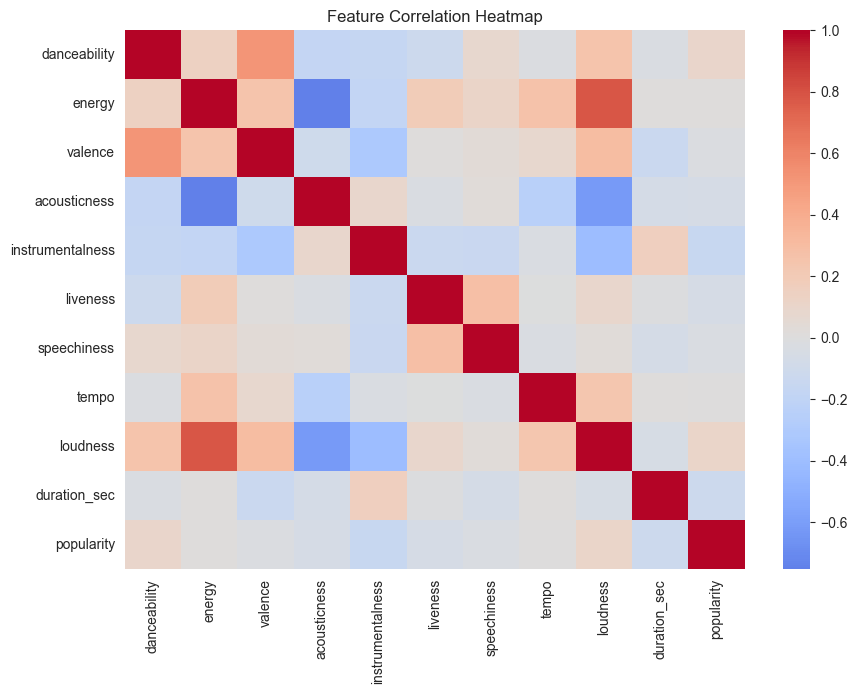

In [43]:
plt.figure(figsize=(10, 7))
sns.heatmap(df_scaled[feature_cols].corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


## Step 6: Save Processed Dataset

We save the cleaned and scaled dataset for modeling.


In [44]:
from pathlib import Path

out_path = Path("../../data/processed/spotify_features.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
df_scaled.to_csv(out_path, index=False)
print(f"✅ Saved processed dataset to {out_path}")



✅ Saved processed dataset to ../../data/processed/spotify_features.csv


## Summary of Preprocessing

| Step | Output | Description |
|------|---------|-------------|
| Load & inspect | `spotify_1m.csv` | 1M-track Spotify dataset |
| Clean & deduplicate | `df` | Removed missing and duplicate entries |
| Feature engineering | Acoustic + rhythmic features | 11 key numeric attributes |
| Scaling | `StandardScaler` | Saved in `ml/utils/spotify_scaler.pkl` |
| Output | `spotify_features.parquet` | Ready for modeling |

---

Next notebook: **02_modeling.ipynb** — build ML-based recommendation models.
